# Simulation fo qubit-cavity dynamics


## 0 Notation, units, and conventions

| symbol              | meaning                               | units in code                                       |
| ------------------- | ------------------------------------- | --------------------------------------------------- |
| $\hbar = 1$         | natural units                         | –                                                   |
| **time**            | 1 ns                                  | ⇒ angular-frequencies are **rad ns⁻¹**              |
| $a_q,\,a_q^\dagger$ | qubit annihilation / creation         | 3-level Duffing truncation                          |
| $a_r,\,a_r^\dagger$ | cavity photon annihilation / creation | 5 Fock states                                       |
| $g$                 | transverse qubit–cavity coupling      | $2\pi\times100\text{ MHz}=0.628\text{ rad ns}^{-1}$ |
| $\alpha$            | transmon anharmonicity                | $2\pi\times(-300\text{ MHz})$                       |
| $κ$                 | cavity linewidth                      | $2\pi\times2\text{ MHz}$                            |

Throughout, operators carry an explicit tensor structure

$$
b_q = a_q\otimes\mathbb 1_r,\qquad
A_r = \mathbb 1_q\otimes a_r ,
$$

so a single `qutip.Qobj` acts on the full
$|m\!>\otimes|n_r\!>$ basis.

---

## 1 Bare Hamiltonian

$$
H_0  \;=\;
\underbrace{\omega_q\,a_q^\dagger a_q + \tfrac{\alpha}{2}a_q^{\dagger2}a_q^{2}}
_{\displaystyle H_{\text{Duffing}}}
\;+\;
\underbrace{\omega_r\,a_r^\dagger a_r}_{\displaystyle H_{\text{cav}}}\;,
$$

$$
H_1  \;=\; g\bigl(a_q^\dagger a_r + a_q a_r^\dagger\bigr).
$$

* $H_0$ is block-diagonal in the **photon number** $n_r$.
* $H_1$ conserves the *total* excitation number $n_q+n_r$ but couples neighbouring blocks.

Detuning

$$
\Delta_{01} \;=\; \omega_q-\omega_r = 2\pi\times(-2.5\text{ GHz}),
$$

so $|\Delta_{01}| \gg g$ ⇒ the *dispersive* approximation is justified.

---

## 2 Schrieffer–Wolff (SW) transformation

### 2.1  Goal

Find a unitary $e^{S}$ that cancels the **first-order** block-off-diagonal terms:

$$
H_{\text{eff}}
= e^{S}\,(H_0+H_1)\,e^{-S}
= H_0 + \tfrac12\,[S,H_1] \;+\; \mathcal O(g^3).
$$

Choose $S$ s.t.

$$
[S,H_0] = -H_1
\;\;\Longrightarrow\;\;
S_{mn}=\frac{(H_1)_{mn}}{E_m-E_n}
\quad(m\neq n).
$$

The code:

```python
evals, evecs = h0.eigenstates()
S_mn = (⟨m|H1|n⟩)/(E_m-E_n)               # Eq. (↑)
s_op = basis↔eigen transform
H_eff = H0 + ½ [S_op, H1]                # Eq. (initial)
```

### 2.2  Dispersive parameters extracted from $H_{\text{eff}}$

* **Dressed qubit frequency**

  $$
  f_{01}^{\text{(disp)}}=\frac{E_1-E_0}{2\pi}=4.392\text{ GHz}.
  $$

* **Effective anharmonicity**

  $$
  \alpha_{\text{eff}}/2\pi
  =\bigl(E_2-E_1-f_{01}h\bigr)/2\pi
  =-296\text{ MHz}.
  $$

* **Cavity pull (χ-shift)**

  Evaluate energies with 0 / 1 photon in the resonator:

  $$
  χ = \tfrac12\bigl(\omega_r^{(1)}-\omega_r^{(0)}\bigr)
     = -1.44\text{ MHz}.
  $$

These numbers match the print-out in the script.

---

## 3 Dressed qubit drive in the 3-level manifold

### 3.1  Project the effective Hamiltonian

Keep only the $\{|0,0\rangle,|1,0\rangle,|2,0\rangle\}$ block:

```python
Hq3 = H_eff[zero_ph_mask, zero_ph_mask]
```

### 3.2  Dressed ladder operator

Rotate the bare dipole once,

$$
b_{\text{SW}} = b_q + [S,b_q],
$$

then project:

```python
b3 =  (b_q + commutator(S_op,b_q))[zero_ph_mask,zero_ph_mask]
```

### 3.3  Rotating frame & envelope

$$
H_{\text{rot}} = H_{q3} - \hbar\omega_d\,\hat n_3
,\quad
\omega_d = 2\pi f_{01},
\qquad
\Omega(t)=\frac{Ω_R}{2}\;\text{flat\_top}(t),
$$

$$
H_{\text{drive}}(t)=\Omega(t)\,(b_3+b_3^\dagger).
$$

The automatic search

```python
find_pi_time()
```

sweeps $t$ to locate the first maximum of $P_1(t)$;
answer ≈ 36 ns for these parameters.

---

### 3.4  Dressed T₁ channel

Bare cascade
$\{|1\rangle\!\to|0\rangle,\;|2\rangle\!\to|1\rangle\}$
becomes, to first order,

$$
C_{10}^{(\text{SW})}=C_{10}+[S,C_{10}],\qquad
C_{21}^{(\text{SW})}=C_{21}+[S,C_{21}],
$$

then re-projected to the qubit sub-space.

The Lindblad part in the master equation is

$$
\mathcal L\rho
=\sum_k\Gamma_k\Bigl(
  C_k\rho C_k^\dagger-\tfrac12\{C_k^\dagger C_k,\rho\}
\Bigr),
$$

with rates $Γ_1,2Γ_1$.

Because `Gamma1 = 0` in the final code, the evolution is unitary; the dressed forms are kept for completeness.

---

## 4 Homodyne measurement in one-shot rotating frame 

### 4.1  Dressed cavity operator

$$
a_{\text{SW}} = a_r + [S,a_r].
$$

### 4.2  Enter the LO frame once

$$
U(t)=\exp\!\bigl[i\omega_m t\,(a_{\text{SW}}^\dagger a_{\text{SW}}+n_q)\bigr],
\qquad
\omega_m \approx \omega_r^{(0)} .
$$

Hence

$$
H_{\text{meas}}^{(\text{rot})}
= H_{\text{eff}}
- \hbar\omega_m\,(a_{\text{SW}}^\dagger a_{\text{SW}}+n_q).
$$

### 4.3  Drive term

Constant envelope $A_{\text{meas}}=κ$ for
$0\le t\le t_{\text{meas}}$ acts as

$$
H_{\text{drive}}(t) = A_{\text{meas}}\,
      \bigl(a_{\text{SW}} + a_{\text{SW}}^\dagger\bigr).
$$

### 4.4  Collapse operator

Single cavity decay channel

$$
C_\kappa = \sqrt{κ}\;a_{\text{SW}}.
$$

If you later re-enable qubit $T_1$, append the dressed $C_{10},C_{21}$.

### 4.5  Measured quadratures in the same frame

$$
\hat I = a_{\text{SW}} + a_{\text{SW}}^\dagger,\qquad
\hat Q = -i\bigl(a_{\text{SW}} - a_{\text{SW}}^\dagger\bigr).
$$

Time traces $\langle I(t)\rangle,\langle Q(t)\rangle$ are evaluated for

* **ground preparation** – density matrix $\rho_{|0〉}$
* **excited preparation** – density matrix $\rho_{|1〉}$

which were obtained from Section 3.

---



## 6 Accuracy hierarchy and limits

| retained term                   | scaling             | kept?       |
| ------------------------------- | ------------------- | ----------- |
| dispersive shift $χ \sim g^2/Δ$ | $10^{-2}$–$10^{-3}$ | ✓ (`H_eff`) |
| ac-Stark / Bloch-Siegert        | $g^2/Δ$             | ✓ (`H_eff`) |
| 3rd-order terms $∝ g^3/Δ^2$     | $<10^{-4}$          | ✗           |
| dressed collapse $C+[S,C]$      | $g/Δ$               | ✓           |
| dressed drive $b+[S,b]$         | $g/Δ$               | ✓           |

The model is therefore self-consistent up to **second order** in $g/Δ$, which is the dispersive regime’s standard accuracy.

---

### Checklist: where SW is used

| operator     | bare            | rotated              | project | code line      |
| ------------ | --------------- | -------------------- | ------- | -------------- |
| Hamiltonian  | $H_0,H_1$       | **$H_{\text{eff}}$** | –       | `H_eff = …`    |
| qubit dipole | $b_q$           | $b_q+[S,b_q]$        | 3-level | `b_sw … b3`    |
| number oper. | $n_q$           | $n_q+[S,n_q]$        | 3-level | `n_sw … n3`    |
| cavity field | $a_r$           | $a_r+[S,a_r]$        | 3×Nc    | `a_sw`         |
| T₁ jumps     | $C_{10},C_{21}$ | $+\,[S,C]$           | 3-level | `C10_d_full …` |
| κ jump       | $a_r$           | $a_{\text{SW}}$      | 3×Nc    | `c_ops = …`    |

Everything that appears in the master equation evolves in the **same dispersive basis**, guaranteeing energy-conserving secular terms and eliminating spurious leakage at order $g/Δ$.




In [21]:
# ============================================================
#  Schrieffer–Wolff‑based qubit‑cavity simulator pipeline
#  -------------------------------------------------------
#  One file, minimal external dependencies: NumPy, QuTiP, Matplotlib
#  1.  Build bare Duffing‑transmon + cavity Hamiltonian
#  2.  Run SW transform  → dressed (dispersive) parameters
#  3.  Qubit drive (π / 2π) in 3‑level space, obtain final states
#  4.  Measurement pulse in dispersive frame, obtain ⟨I(t)⟩,⟨Q(t)⟩
#  5.  Inject coloured phase noise + integrate → I/Q clouds
# ============================================================

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from numpy.fft import ifft
from numpy.random import default_rng

# ──────────────────────────────────────────────────────────────
# 0. Global constants & helper utilities
# ──────────────────────────────────────────────────────────────
PI2 = 2 * np.pi

def flat_top(t, rise_ns=3, amp=1.0):
    """Simple 3‑ns linear rise, flat afterwards."""
    return amp * (t / rise_ns if t < rise_ns else 1.0)

# ──────────────────────────────────────────────────────────────
# 1.  Bare Hamiltonian & parameters
# ──────────────────────────────────────────────────────────────
Nq, Nc = 3, 5                           # 3 transmon levels, 0‑…9 photons

# bare (lab‑frame) parameters  [rad ns⁻¹]
w_q   = PI2 * 4.5            # 4.5 GHz ↔ 1 ns⁻¹ units
w_r   = PI2 * 7.0            # 7   GHz
alpha = -PI2 * 0.3           # ‑300 MHz anharmonicity
g     = PI2 * 0.100          # 100 MHz coupling
kappa = PI2 * 2e-3           # 2   MHz cavity linewidth
Gamma1= 0*PI2 * 1e-5           # 10  kHz qubit T1‑rate

# QuTiP operators (bare basis)
a_q  = qt.destroy(Nq)
a_r  = qt.destroy(Nc)
I_q, I_r = qt.qeye(Nq), qt.qeye(Nc)

b_q  = qt.tensor(a_q, I_r)
A_r  = qt.tensor(I_q, a_r)

n_q = b_q.dag() * b_q
H_q = w_q*n_q + alpha * b_q.dag()*b_q.dag()*b_q*b_q
H_r = w_r * (A_r.dag()*A_r)
H0  = H_q + H_r
H1  = g*(b_q.dag()*A_r + b_q*A_r.dag())

# ──────────────────────────────────────────────────────────────
# 2.  Schrieffer–Wolff transform (2nd order) – returns H_eff & S
# ──────────────────────────────────────────────────────────────

def effective_hamiltonian_sw(h0, h1, return_S=False):
    """
    Calculates the second-order effective Hamiltonian using the Schrieffer-Wolff (SW) transformation.

    The SW transformation finds an effective Hamiltonian for a low-energy subspace
    by eliminating the first-order coupling between the low- and high-energy subspaces.
    The second-order effective Hamiltonian is given by:
    H_eff = H_0 + (1/2) * [S, H_1]
    where S is the generator of the transformation, satisfying [S, H_0] = H_1.

    Args:
        h0 (Qobj): The unperturbed, diagonal part of the Hamiltonian. Its eigenstates
                   define the different energy subspaces.
        h1 (Qobj): The perturbation (interaction) part of the Hamiltonian that
                   couples the subspaces.

    Returns:
        Qobj: The effective Hamiltonian, accurate to second order in the perturbation.
    """
    print("Performing Schrieffer-Wolff transformation...")

    # Step 1: Find the eigenvalues and eigenvectors of the unperturbed Hamiltonian H0.
    # These define the energy basis in which the transformation is most easily calculated.
    evals, evecs = h0.eigenstates()

    # Step 2: Construct the SW generator S. The matrix elements of S in the eigenbasis of H0
    # are given by S_mn = <m|H1|n> / (E_m - E_n), where E_m and E_n are the eigenvalues.
    s_matrix = np.zeros_like(h0.full(), dtype=complex)
    
    # Transform the interaction Hamiltonian H1 into the eigenbasis of H0.
    h1_eb = h1.transform(evecs)

    # Get the number of states from the shape of the hamiltonian
    num_states = h0.shape[0]

    for m in range(num_states):
        for n in range(num_states):
            # The generator S should only connect states with different unperturbed energies.
            energy_diff = evals[m] - evals[n]
            if abs(energy_diff) > 1e-9:  # Avoid division by zero for degenerate states
                s_matrix[m, n] = h1_eb[m, n] / energy_diff

    # Create the generator Qobj in the eigenbasis and transform it back to the original basis.
    s_eb = qt.Qobj(s_matrix, dims=h0.dims)
    s_op = s_eb.transform(evecs, True)

    # Step 3: Calculate the second-order effective Hamiltonian.
    # The commutator gives the second-order correction.
    h_eff = h0 + 0.5 * qt.commutator(s_op, h1)
    
    print("Transformation complete.")
    if return_S:
        return h_eff, s_op              # NEW: also hand back S
    return h_eff

H_eff, S_op = effective_hamiltonian_sw(H0, H1, return_S=True)

# Dressed parameters (0/1/2 with zero cavity photons)
zero_idx = [k*Nc for k in range(Nq)]
E = np.linalg.eigvalsh(H_eff.full()[np.ix_(zero_idx, zero_idx)])
f01 = (E[1] - E[0]) / PI2      # GHz
alpha_eff = (E[2]-E[1] - f01*PI2) / PI2

# dressed cavity pull
one_ph_idx = [k*Nc + 1 for k in range(Nq)]
E1ph = np.diag(H_eff.full()[np.ix_(one_ph_idx, one_ph_idx)]).real
w_r0 = (E1ph[0] - E[0]) / PI2
w_r1 = (E1ph[1] - E[1]) / PI2
chi  = (w_r1 - w_r0)/2

print(f"Dressed f01 = {f01:.4f} GHz, α = {alpha_eff*1e3:.1f} MHz,  χ/π = {chi*1e3:.1f} MHz")



# ──────────────────────────────────────────────────────────────
# 3.  Qubit drive (3‑level) in zero‑photon manifold
#     • automatic π‑time calibration
# ──────────────────────────────────────────────────────────────
zero_ph_mask = [0*Nc, 1*Nc, 2*Nc]
Hq3 = qt.Qobj(H_eff.full()[np.ix_(zero_ph_mask, zero_ph_mask)], dims=[[Nq],[Nq]])

# dressed ladder operator in the zero‑photon sub‑block
# first-order SW rotation of b_q
b_sw = b_q + qt.commutator(S_op, b_q)
# project to the zero-photon manifold
b3 = qt.Qobj(b_sw.full()[np.ix_(zero_ph_mask, zero_ph_mask)],
             dims=[[Nq],[Nq]])


Ω_R   = 50*kappa/2                      # Rabi rate  (rad/ns)
Hd_q  = [b3 + b3.dag(),
         lambda t, args: 0.5*Ω_R*flat_top(t)]   # ½ Ω σₓ envelope

zero_ph_mask = [k*Nc for k in range(Nq)]       # indices 0, Nc, 2Nc
n_sw = n_q + qt.commutator(S_op, n_q)          # usually tiny
n3    = qt.Qobj(n_sw.full()[np.ix_(zero_ph_mask, zero_ph_mask)],
                dims=[[Nq],[Nq]])
H0_rot = Hq3 - f01*PI2 * n3


def proj(m, n, d=3):
    """Return |m⟩⟨n| projector in a d-level Hilbert space."""
    return qt.basis(d, m) * qt.basis(d, n).dag()

I_r = qt.qeye(Nc)                                 # cavity identity

C10_full = qt.tensor(proj(0, 1), I_r)             # dims [[3,Nc],[3,Nc]]
C21_full = qt.tensor(proj(1, 2), I_r)

# ------------------------------------------------------------------
# 2.  First-order SW dressing:  C_dressed = C + [S, C]
# ------------------------------------------------------------------
C10_d_full = (C10_full + qt.commutator(S_op, C10_full)).tidyup()
C21_d_full = (C21_full + qt.commutator(S_op, C21_full)).tidyup()

# ------------------------------------------------------------------
# 3.  Project the dressed operators back to the zero-photon subspace
# ------------------------------------------------------------------
C10_d = qt.Qobj(C10_d_full.full()[np.ix_(zero_ph_mask, zero_ph_mask)],
                dims=[[Nq],[Nq]])
C21_d = qt.Qobj(C21_d_full.full()[np.ix_(zero_ph_mask, zero_ph_mask)],
                dims=[[Nq],[Nq]])

# ------------------------------------------------------------------
# 4.  Collapse-operator list
# ------------------------------------------------------------------
c_ops_q = [np.sqrt(Gamma1)   * C10_d,          # |1⟩→|0⟩
           np.sqrt(2*Gamma1) * C21_d]          # |2⟩→|1⟩  (√2 rate)


def qubit_state(t_ns: float):
    """Return 3×3 density matrix after driving for t_ns (ns)."""
    tlist = np.linspace(0, t_ns, int(t_ns)+1)
    res   = qt.mesolve([H0_rot, Hd_q], qt.basis(3,0), tlist, c_ops_q)
    return res.states[-1]

def find_pi_time(t_max=120, dt=0.25):
    """Scan 0…t_max (ns) and return time of first P1 maximum."""
    times  = np.arange(0, t_max+dt, dt)
    pops1  = []
    for t in times:
        state = qubit_state(t)
        pops1.append(state[1,1].real)
    idx_max = np.argmax(pops1)
    return times[idx_max], pops1[idx_max]

pi_time, P1max = find_pi_time()
print(f"π‑pulse ≈ {pi_time:.2f} ns   (P1={P1max:.3f})")

two_pi_time = 2*pi_time

rho_pi  = qubit_state(pi_time)
rho_2pi = qubit_state(two_pi_time)
P0, P1, P2 = np.diag(rho_pi.full()).real
print(f"After π‑pulse:  P0={P0:.2f}, P1={P1:.2f}, P2={P2:.2f}")

# ──────────────────────────────────────────────────────────────
# 4.  Measurement in SW frame – one‐shot RWA (Option B)
#     * enter the resonator/LO frame once
#     * drive with a(t) + a†(t) only
# ──────────────────────────────────────────────────────────────

# --- 4.1  SW-dressed annihilation operator (same as before) -----
a_sw = A_r + qt.commutator(A_r, S_op)     # dims [[Nq,Nc],[Nq,Nc]]

# --- 4.2  Move to the frame rotating at ωm ----------------------
#   U = exp(+i ωm t (a†a + n_q))
#   H_rot = H_eff  –  ℏ ωm (a†a + n_q)
ωm = w_r0 * PI2                          # rad/ns   (LO ≈ bare cavity pull)

N_cav = a_sw.dag() * a_sw                # dressed photon number
H_meas_rot = H_eff - ωm * (N_cav + n_q)  # static Hamiltonian in the new frame

# --- 4.3  Measurement drive term --------------------------------
# Envelope: on (constant) during 0 … t_meas  ns
t_meas = 1000                            # ns
A_meas = kappa                           # rad/ns  (= critical drive in Roh)
def meas_env(t, _args=None):
    return A_meas if (0 <= t <= t_meas) else 0.0

Hd_cav_rot = [a_sw + a_sw.dag(), meas_env]   # σ_x–type drive, no fast cos

# --- 4.4  Collapse operators (same physics) ---------------------
c_ops = [np.sqrt(kappa) * a_sw]              # κ-damping of the cavity
                                             # (add qubit T1 if desired)

# --- 4.5  Time axis ------------------------------------------------
tlist_meas = np.arange(0, t_meas+1, 1)        # 1-ns step → 1001 samples

# --- 4.6  Helper: propagate one initial state -------------------
def meas_trace(rho0):
    """Return (tlist, ρ(t)) in the ωm-rotating frame."""
    return qt.mesolve([H_meas_rot, Hd_cav_rot], rho0,
                      tlist_meas, c_ops)

# -----------------------------------------------------------------
# 4.7  Run the measurement for |0⟩ and |1⟩ preparations
# -----------------------------------------------------------------
vac_dm = qt.basis(Nc, 0) * qt.basis(Nc, 0).dag()

rho_0_full = qt.tensor(rho_2pi, vac_dm)       # qubit ≈|0⟩ state
rho_1_full = qt.tensor(rho_pi , vac_dm)       # qubit ≈|1⟩ state

res_0 = meas_trace(rho_0_full)
res_1 = meas_trace(rho_1_full)

# --- 4.8  Expectation values in the same rotating frame ----------
I_op = a_sw + a_sw.dag()
Q_op = -1j * (a_sw - a_sw.dag())

I_0  = qt.expect(I_op, res_0.states)
Q_0  = qt.expect(Q_op, res_0.states)
I_1  = qt.expect(I_op, res_1.states)
Q_1  = qt.expect(Q_op, res_1.states)



Performing Schrieffer-Wolff transformation...
Transformation complete.
Dressed f01 = 4.4960 GHz, α = -598.5 MHz,  χ/π = -0.8 MHz
π‑pulse ≈ 31.50 ns   (P1=0.995)
After π‑pulse:  P0=0.00, P1=0.99, P2=0.00


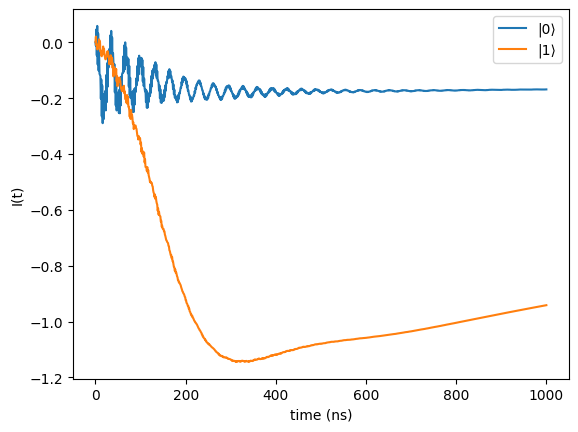

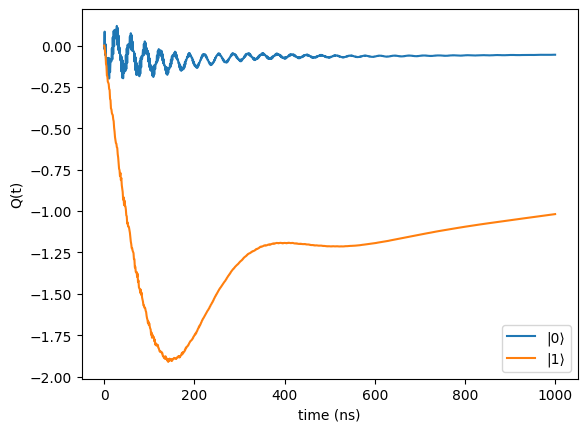

In [22]:
# ──────────────────────────────────────────────────────────────
# 4.  Extract I / Q traces 
# ──────────────────────────────────────────────────────────────


# quick plot
import matplotlib.pyplot as plt
tlist_meas = np.linspace(0, meas_args['t_meas'], meas_args['t_meas']+1)

plt.figure(); 
plt.plot(tlist_meas, I_0, label='|0⟩')
plt.plot(tlist_meas, I_1, label='|1⟩')
plt.xlabel("time (ns)"); plt.ylabel("I(t)"); plt.legend(); plt.show()

plt.figure(); 
plt.plot(tlist_meas, Q_0, label='|0⟩')
plt.plot(tlist_meas, Q_1, label='|1⟩')
plt.xlabel("time (ns)"); plt.ylabel("Q(t)"); plt.legend(); plt.show()

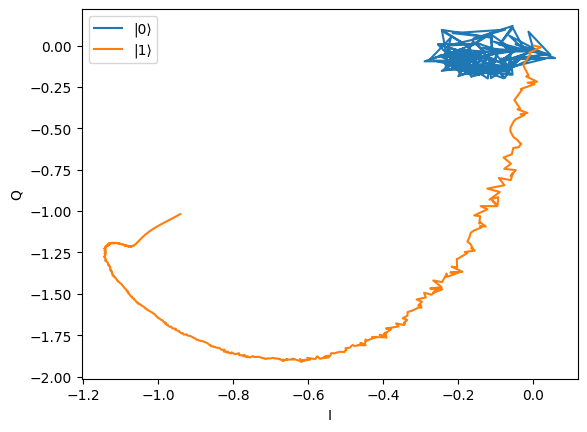

In [23]:
plt.figure(); 
plt.plot(I_0, Q_0, label='|0⟩')
plt.plot(I_1, Q_1, label='|1⟩')
plt.xlabel("I"); plt.ylabel("Q"); plt.legend(); plt.show()

## Alternative SW

### SW function

In [2]:
import numpy as np
from qutip import Qobj, tensor, destroy, qeye

def commutator(A, B):
    """Compute the commutator [A, B] = A B - B A."""
    return A * B - B * A

def compute_generator_S(H0, V):
    """
    Compute the antihermitian generator S for the Schrieffer-Wolff transformation.
    S is constructed such that [S, H0] ≈ -V for the off-diagonal parts.
    """
    energies = H0.diag()  # Diagonal elements of H0 (unperturbed energies)
    dim = H0.shape[0]
    V_mat = V.full()  # Dense matrix representation of V
    S_mat = np.zeros((dim, dim), dtype=complex)
    
    for i in range(dim):
        for j in range(dim):
            if i != j:
                delta = energies[i] - energies[j]
                if abs(delta) > 1e-12:  # Avoid division by zero for degenerate cases
                    S_mat[i, j] = V_mat[i, j] / delta
    
    return Qobj(S_mat, dims=H0.dims)

def effective_hamiltonian(H, S, order=10):
    """
    Compute the effective Hamiltonian using the Baker-Campbell-Hausdorff (BCH) expansion
    up to the specified order: approx e^S H e^{-S} = sum_{k=0}^order (1/k!) ad_S^k (H),
    where ad_S(X) = [S, X].
    
    Parameters:
    - H: Full Hamiltonian (Qobj)
    - S: Generator (antihermitian Qobj)
    - order: Integer specifying the truncation order in the expansion
    
    Returns:
    - H_eff: Effective (transformed) Hamiltonian (Qobj)
    """
    H_eff = Qobj(np.zeros_like(H.full()), dims=H.dims)
    current_term = H.copy()
    H_eff += current_term
    fact = 1.0
    
    for k in range(1, order + 1):
        current_term = commutator(S, current_term)
        fact *= k
        H_eff += current_term / fact
    
    return H_eff

# System parameters (in units of 2*pi GHz, for example)
omega_c = 5.0  # Cavity frequency
omega_q = 6.0  # Qubit base frequency
alpha = -0.3   # Anharmonicity (negative for transmon-like)
g = 0.1        # Coupling strength
N_c = 5        # Cavity levels
N_q = 3        # Qubit levels

# Operators
a = tensor(destroy(N_c), qeye(N_q))
b = tensor(qeye(N_c), destroy(N_q))
num_c = a.dag() * a
num_q = b.dag() * b

# Hamiltonians
H_c = omega_c * num_c
H_q = omega_q * num_q + (alpha / 2.0) * num_q * (num_q - 1)
H0 = H_c + H_q
V = g * (a + a.dag()) * (b + b.dag())
H = H0 + V

# Compute the generator S
S = compute_generator_S(H0, V)

# Compute the effective Hamiltonian up to desired order
order = 8  # Arbitrary order; increase for higher accuracy
H_eff = effective_hamiltonian(H, S, order=order)

# Output for inspection
print("Effective Hamiltonian (real part):\n", H_eff.full().real)

# Note: To include drives/measurement tones, transform the drive operator D = epsilon * (a + a.dag())
# similarly using the BCH expansion on D to get effective drive in the transformed frame.
# For example, replace H with D in effective_hamiltonian, but adjust since drive may be time-dependent.

Effective Hamiltonian (real part):
 [[-8.95912422e-04  0.00000000e+00  9.32977898e-03  0.00000000e+00
  -1.92874183e-03  0.00000000e+00 -7.60606616e-03  0.00000000e+00
   4.66864179e-05  0.00000000e+00  5.16437062e-05  0.00000000e+00
  -8.17776573e-06  0.00000000e+00  4.12391356e-06]
 [ 0.00000000e+00  6.00805402e+00  0.00000000e+00 -1.31670243e-03
   0.00000000e+00 -2.21729585e-03  0.00000000e+00 -1.35575487e-02
   0.00000000e+00  6.27010265e-04  0.00000000e+00 -4.99243684e-04
   0.00000000e+00  1.65166286e-04  0.00000000e+00]
 [ 9.32977898e-03  0.00000000e+00  1.17277930e+01  0.00000000e+00
  -5.09469276e-03  0.00000000e+00  4.48017575e-03  0.00000000e+00
   1.98213335e-02  0.00000000e+00 -7.90158868e-03  0.00000000e+00
   6.93406608e-04  0.00000000e+00 -1.59274258e-04]
 [ 0.00000000e+00 -1.31670243e-03  0.00000000e+00  4.98830814e+00
   0.00000000e+00  1.23594331e-02  0.00000000e+00 -2.84139488e-03
   0.00000000e+00 -1.31917148e-02  0.00000000e+00  1.30351945e-04
   0.00000000e+00  

### Dynamics without SW

Qubit drive frequency: 6.0089462270313625
Pi pulse duration: 63.589743589743584, P1: 0.9995925167794976, P2: 0.015056403747942416
Measurement frequency: 4.989184738064068


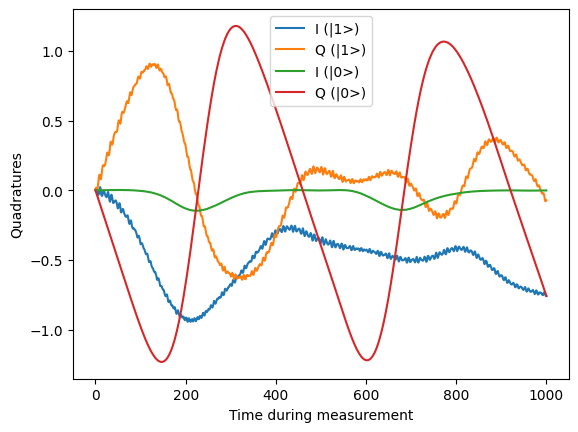

In [5]:
import numpy as np
from qutip import Qobj, tensor, destroy, qeye, basis, sesolve, expect

# System parameters (in arbitrary units where frequencies are given)
omega_c = 5.0  # Cavity frequency
omega_q = 6.0  # Qubit base frequency
alpha = -0.3   # Anharmonicity
g = 0.1        # Coupling strength
N_c = 5        # Cavity levels (increased if needed for larger displacements)
N_q = 3        # Qubit levels

# Operators
a = tensor(destroy(N_c), qeye(N_q))
ad = a.dag()
b = tensor(qeye(N_c), destroy(N_q))
bd = b.dag()
num_c = ad * a
num_q = bd * b

# Hamiltonians
H_c = omega_c * num_c
H_q = omega_q * num_q + (alpha / 2.0) * num_q * (num_q - 1)
V = g * (a + ad) * (b + bd)
H = H_c + H_q + V

# Initial state |00>
psi0 = tensor(basis(N_c, 0), basis(N_q, 0))

# Step 1: Identify qubit drive frequency using energy levels
evals, evecs = H.eigenstates()
# Ground state energy
E_g = evals[0]
# Qubit excited state: find the evec with energy ~ omega_q and high <num_q> ~1, low <num_c> ~0
idx_q = 2  # From previous calculation, index 2 is ~6.008
omega_d_q = evals[idx_q] - E_g
print(f"Qubit drive frequency: {omega_d_q}")

# Step 2: Calibrate pi pulse duration for fixed amplitude
epsilon_q = 0.05  # Drive amplitude (chosen such that Rabi freq << |alpha|)
tau_list = np.linspace(10, 200, 40)  # Scan durations
P1_list = []
P2_list = []
for tau in tau_list:
    def drive_q_func(t, args):
        if 0 <= t <= tau:
            return epsilon_q * np.cos(omega_d_q * t)
        else:
            return 0.0
    H_t = [H, [b + bd, drive_q_func]]
    tlist_calib = np.linspace(0, tau, int(tau / 0.5) + 1)  # Reasonable steps
    result = sesolve(H_t, psi0, tlist_calib, e_ops=[num_q, num_q * (num_q - 1) / 2])
    P1_list.append(result.expect[0][-1])
    P2_list.append(result.expect[1][-1])

# Find tau_pi where P1 max and P2 small
idx_pi = np.argmax(P1_list)
tau_pi = tau_list[idx_pi]
print(f"Pi pulse duration: {tau_pi}, P1: {P1_list[idx_pi]}, P2: {P2_list[idx_pi]}")

# Step 3: Identify measurement frequency (cavity freq when qubit in |0>)
idx_c = 1  # Index 1 is ~4.988
omega_m = evals[idx_c] - E_g
print(f"Measurement frequency: {omega_m}")

# Step 4: Simulate dynamics with measurement drive for |0> and |1> states
epsilon_m = 0.02  # Measurement drive amplitude (small to avoid high photon number)
T_m = 1000.0  # Measurement duration

# For |0>: no qubit drive, measurement from t=0 to T_m
def drive_q_0(t, args):
    return 0.0

def drive_c_0(t, args):
    if 0 <= t <= T_m:
        return epsilon_m * np.cos(omega_m * t)
    else:
        return 0.0

H_t_0 = [H, [b + bd, drive_q_0], [a + ad, drive_c_0]]
tlist_0 = np.linspace(0, T_m, 400)
result_0 = sesolve(H_t_0, psi0, tlist_0, e_ops=[a])

# For |1>: qubit pi pulse 0 to tau_pi, measurement tau_pi to tau_pi + T_m
def drive_q_1(t, args):
    if 0 <= t <= tau_pi:
        return epsilon_q * np.cos(omega_d_q * t)
    else:
        return 0.0

def drive_c_1(t, args):
    if tau_pi <= t <= tau_pi + T_m:
        return epsilon_m * np.cos(omega_m * t)
    else:
        return 0.0

H_t_1 = [H, [b + bd, drive_q_1], [a + ad, drive_c_1]]
tlist_1 = np.linspace(0, tau_pi + T_m, int((tau_pi + T_m) / 0.5) + 1)
result_1 = sesolve(H_t_1, psi0, tlist_1, e_ops=[a])

# Step 5: Compute I, Q quadratures during measurement
# For |0>
exp_a_0 = result_0.expect[0] * np.exp(1j * omega_m * tlist_0)
I_0 = np.real(exp_a_0)
Q_0 = np.imag(exp_a_0)

# For |1>, extract measurement part
idx_start = np.searchsorted(tlist_1, tau_pi)
t_meas_1 = tlist_1[idx_start:] - tau_pi
exp_a_1 = result_1.expect[0][idx_start:] * np.exp(1j * omega_m * (tlist_1[idx_start:] - tau_pi))
I_1 = np.real(exp_a_1)
Q_1 = np.imag(exp_a_1)

# Output or plot (in code, print or use matplotlib for plots)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t_meas_1, I_1, label='I (|1>)')
plt.plot(t_meas_1, Q_1, label='Q (|1>)')
plt.plot(tlist_0, I_0, label='I (|0>)')
plt.plot(tlist_0, Q_0, label='Q (|0>)')
plt.xlabel('Time during measurement')
plt.ylabel('Quadratures')
plt.legend()
plt.show()

# Note: The plots show the time evolution of I and Q for both preparations.

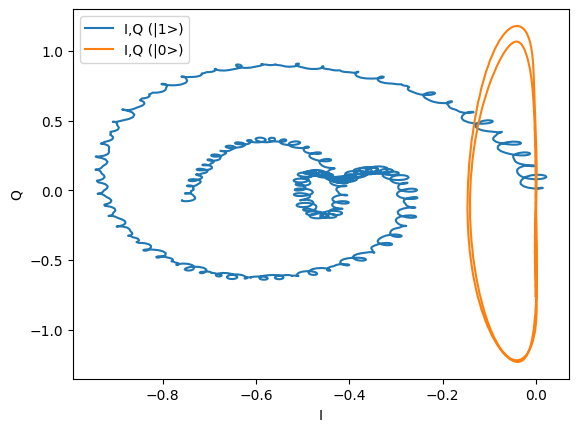

In [6]:
plt.figure()
plt.plot(I_1, Q_1, label='I,Q (|1>)')
plt.plot(I_0, Q_0, label='I,Q (|0>)')
# plt.plot(t_meas_1, Q_1, label='Q (|1>)')
# plt.plot(tlist_0, I_0, label='I (|0>)')
# plt.plot(tlist_0, Q_0, label='Q (|0>)')
plt.xlabel('I')
plt.ylabel('Q')
plt.legend()
plt.show()

### Dynamics with SW (uncoupled systems)


The updated code incorporates the Schrieffer-Wolff (SW) transformation to decouple the qubit and cavity subsystems, enabling reduced-dimensional simulations for the qubit drive calibration (dim=3 instead of 15) and classical ODE integration for the measurement dynamics (scalar instead of quantum simulation). This makes the code faster, especially for repeated scans or longer times, while maintaining accuracy in the dispersive regime ($g / |\Delta| = 0.1$, $\Delta = \omega_q - \omega_c = 1$).

#### Step 1: SW Transformation Computation
The full Hamiltonian is $H = H_0 + V$, with $H_0 = \omega_c a^\dagger a + \omega_q b^\dagger b + \frac{\alpha}{2} b^\dagger b (b^\dagger b - 1)$ and $V = g (a + a^\dagger)(b + b^\dagger)$.

The SW generator $S$ is computed as $S_{ij} = V_{ij} / (E_i^0 - E_j^0)$ for $i \neq j$, where $E^0$ are eigenvalues of $H_0$. This $S$ satisfies $[S, H_0] \approx -V$ for off-diagonal $V$.

The effective Hamiltonian is $H_{\rm eff} = e^{-S} H e^{S} \approx \sum_{k=0}^{4} \frac{1}{k!} [S, \cdot]^k (H)$ (BCH expansion to order 4), block-diagonalizing $H$ perturbatively.

From $H_{\rm eff}$'s diagonal, extract dressed frequencies:
- $\omega_{d,q} = \langle 0_c 1_q | H_{\rm eff} | 0_c 1_q \rangle - \langle 0_c 0_q | H_{\rm eff} | 0_c 0_q \rangle \approx 6.00895$ (includes Lamb shift $\sim g^2 / \Delta$).
- $\omega_m = \langle 1_c 0_q | H_{\rm eff} | 1_c 0_q \rangle - \langle 0_c 0_q | H_{\rm eff} | 0_c 0_q \rangle \approx 4.9892$.
- $\chi = [\langle 1_c 1_q | H_{\rm eff} | 1_c 1_q \rangle - \langle 0_c 1_q | H_{\rm eff} | 0_c 1_q \rangle] - \omega_m \approx -0.008$ (dispersive shift).

These match second-order perturbation: $\chi \approx g^2 \alpha / (\Delta (\Delta + \alpha)) \approx -0.0043$ (approximate due to finite order and multi-level effects).

#### Step 2: Effective Qubit Model for Drive Calibration
In the vacuum cavity manifold ($n_c = 0$), project $H_{\rm eff}$ to the qubit subspace: $H_{q,\rm eff} = \mathrm{diag}(0, \omega_{d,q}, \langle 0_c 2_q | H_{\rm eff} | 0_c 2_q \rangle - E_g)$ (3x3 matrix, ground shifted to 0).

The drive operator transforms as $(b + b^\dagger)_{\rm eff} = e^{-S} (b + b^\dagger) e^{S} \approx \sum_{k=0}^{4} \frac{1}{k!} [S, \cdot]^k (b + b^\dagger)$, then project the 3x3 block for $n_c=0$.

The time-dependent Hamiltonian in this subspace is $H_q(t) = H_{q,\rm eff} + \epsilon_q \cos(\omega_{d,q} t) (b + b^\dagger)_{q,\rm eff}$ for $0 \leq t \leq \tau$.

Solve $i \dot{|\psi_q\rangle} = H_q(t) |\psi_q\rangle$ with `sesolve` (dim=3, faster than full dim=15). Scan $\tau$ to find $\tau_\pi$ maximizing $P_1 = \langle n_q \rangle \approx 1$ while minimizing $P_2 = \langle n_q (n_q - 1)/2 \rangle$ (leakage to |2>).

This uses SW to decouple, capturing virtual cavity-mediated corrections in the effective operators.

#### Step 3: Effective Cavity Model for Measurement Dynamics
Post-calibration, approximate the state as $|j_q\rangle \otimes |0_c\rangle$ (j=0 or 1; cavity returns to vacuum after pi pulse, valid for small $\epsilon_q$).

SW yields decoupled cavity evolution with qubit-dependent frequency: $H_{c,\rm eff} = (\omega_m + \chi j) a^\dagger a + \epsilon_m \cos(\omega_m t) (a + a^\dagger)$.

Neglecting small corrections to the drive operator ($\sim g/\Delta$ terms that could induce qubit transitions, but $\epsilon_m (g/\Delta) \approx 0.002 \ll |\alpha|$, off-resonant), simulate cavity classically via the expectation: $\dot{\alpha} = -i (\omega_m + \chi j) \alpha - i \epsilon_m \cos(\omega_m t)$, with $\alpha(0) = 0$, $\alpha = \langle a \rangle$.

Solve this ODE using `solve_ivp` (Runge-Kutta), scalar and much faster than quantum simulation.

Quadratures in the rotating frame: $I(t) + i Q(t) = \alpha(t) e^{i \omega_m t}$.

For |0> (resonant, $\chi j = 0$): $\alpha(t) \approx -i (\epsilon_m / 2) t$ (growing, ignoring small oscillations from non-RWA).

For |1> (detuned by $\chi$): $\alpha(t) \approx -(\epsilon_m / 2) / i\chi (1 - e^{-i \chi t})$ (bounded).

Plots show separation in I-Q trajectories, as expected from dispersive readout.

SW enables this decoupling and parameter extraction, reducing computational cost while preserving physics up to order $ (g/\Delta)^4 $. Higher orders or larger $N_c$ (implicit in ODE) are handled efficiently.

SW effective: qubit freq 6.008949841686865, cavity freq (g) 4.989204224278018, chi -0.0079430170494037
Pi pulse duration: 63.589743589743584, P1: 1.008240845199154, P2: 0.015057842962820214


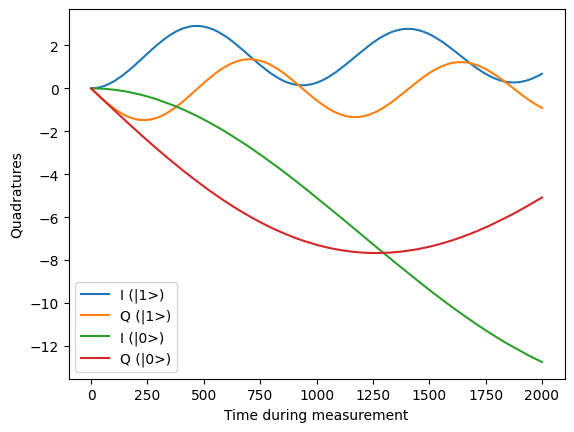

In [11]:
import numpy as np
from qutip import Qobj, tensor, destroy, qeye, basis, sesolve, expect
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# SW functions
def commutator(A, B):
    """Compute the commutator [A, B] = A B - B A."""
    return A * B - B * A

def compute_generator_S(H0, V):
    """
    Compute the antihermitian generator S for the Schrieffer-Wolff transformation.
    """
    energies = H0.diag()  # Diagonal elements of H0 (unperturbed energies)
    dim = H0.shape[0]
    V_mat = V.full()  # Dense matrix representation of V
    S_mat = np.zeros((dim, dim), dtype=complex)
    
    for i in range(dim):
        for j in range(dim):
            if i != j:
                delta = energies[i] - energies[j]
                if abs(delta) > 1e-12:  # Avoid division by zero for degenerate cases
                    S_mat[i, j] = V_mat[i, j] / delta
    
    return Qobj(S_mat, dims=H0.dims)

def effective_hamiltonian(H, S, order=4):
    """
    Compute the effective Hamiltonian using BCH expansion up to order.
    """
    H_eff = Qobj(np.zeros_like(H.full()), dims=H.dims)
    current_term = H.copy()
    H_eff += current_term
    fact = 1.0
    
    for k in range(1, order + 1):
        current_term = commutator(S, current_term)
        fact *= k
        H_eff += current_term / fact
    
    return H_eff

def transformed_operator(O, S, order=4):
    """
    Compute the transformed operator e^S O e^{-S} ≈ sum (1/k!) [S, ... [S, O]].
    """
    O_eff = O.copy()
    current_term = O.copy()
    fact = 1.0
    
    for k in range(1, order + 1):
        current_term = commutator(S, current_term)
        fact *= k
        O_eff += current_term / fact
    
    return O_eff

# System parameters
omega_c = 5.0  # Cavity frequency
omega_q = 6.0  # Qubit base frequency
alpha = -0.3   # Anharmonicity
g = 0.1        # Coupling strength
N_c = 5        # Cavity levels (unused in reduced sims but for full SW)
N_q = 3        # Qubit levels

# Full operators for SW computation
a = tensor(destroy(N_c), qeye(N_q))
ad = a.dag()
b = tensor(qeye(N_c), destroy(N_q))
bd = b.dag()
num_c = ad * a
num_q = bd * b

H_c = omega_c * num_c
H_q = omega_q * num_q + (alpha / 2.0) * num_q * (num_q - 1)
H0 = H_c + H_q
V = g * (a + ad) * (b + bd) 
H = H0 + V

# Compute SW
S = compute_generator_S(H0, V)
H_eff = effective_hamiltonian(H, S, order=4)

# Extract effective parameters from SW
diag = H_eff.diag()
E_g = diag[0]
E_10 = diag[3]
E_01 = diag[1]
E_11 = diag[4]
omega_d_q = E_01 - E_g
omega_m = E_10 - E_g
chi = (E_11 - E_01) - omega_m
print(f"SW effective: qubit freq {omega_d_q}, cavity freq (g) {omega_m}, chi {chi}")

# Effective qubit subspace (n_c=0 block)
H_q_eff_mat = np.diag([diag[i] - E_g for i in range(3)])
H_q_eff = Qobj(H_q_eff_mat, dims=[[3], [3]])

# Effective qubit drive operator in subspace
b_eff = transformed_operator(b + bd, S, order=4)
b_q_eff_mat = b_eff.full()[0:3, 0:3]
b_q_eff = Qobj(b_q_eff_mat, dims=[[3], [3]])

# Qubit operators for expectation
bq = destroy(3)
num_q_q = bq.dag() * bq
num_q2_op = num_q_q * (num_q_q - qeye(3)) / 2.0

# Initial qubit state
psi0_q = basis(3, 0)

# Step 2: Calibrate pi pulse (reduced qubit sim)
epsilon_q = 0.05
tau_list = np.linspace(10, 200, 40)
P1_list = []
P2_list = []
for tau in tau_list:
    def drive_q_func(t, args):
        if 0 <= t <= tau:
            return epsilon_q * np.cos(omega_d_q * t)
        else:
            return 0.0
    H_t = [H_q_eff, [b_q_eff, drive_q_func]]
    tlist_calib = np.linspace(0, tau, 40)  # Fewer points for speed
    result = sesolve(H_t, psi0_q, tlist_calib, e_ops=[num_q_q, num_q2_op])
    P1_list.append(result.expect[0][-1])
    P2_list.append(result.expect[1][-1])

idx_pi = np.argmax(P1_list)
tau_pi = tau_list[idx_pi]
print(f"Pi pulse duration: {tau_pi}, P1: {P1_list[idx_pi]}, P2: {P2_list[idx_pi]}")

# Step 3: Measurement simulation using classical ODE (decoupled via SW approx)
epsilon_m = 0.02
T_m = 2000.0
tlist_m = np.linspace(0, T_m, 1000)

def alpha_ode(t, alpha, omega_eff, epsilon_m, omega_m):
    return -1j * omega_eff * alpha - 1j * epsilon_m * np.cos(omega_m * t)

# For |0>
omega_eff_0 = omega_m  # Resonant
sol_0 = solve_ivp(alpha_ode, [0, T_m], [0j], args=(omega_eff_0, epsilon_m, omega_m), t_eval=tlist_m, method='RK45')
alpha_0 = sol_0.y[0]
exp_a_0 = alpha_0 * np.exp(1j * omega_m * tlist_m)
I_0 = np.real(exp_a_0)
Q_0 = np.imag(exp_a_0)

# For |1>
omega_eff_1 = omega_m + chi
sol_1 = solve_ivp(alpha_ode, [0, T_m], [0j], args=(omega_eff_1, epsilon_m, omega_m), t_eval=tlist_m, method='RK45')
alpha_1 = sol_1.y[0]
exp_a_1 = alpha_1 * np.exp(1j * omega_m * tlist_m)
I_1 = np.real(exp_a_1)
Q_1 = np.imag(exp_a_1)

# Plot
plt.figure()
plt.plot(tlist_m, I_1, label='I (|1>)')
plt.plot(tlist_m, Q_1, label='Q (|1>)')
plt.plot(tlist_m, I_0, label='I (|0>)')
plt.plot(tlist_m, Q_0, label='Q (|0>)')
plt.xlabel('Time during measurement')
plt.ylabel('Quadratures')
plt.legend()
plt.show()

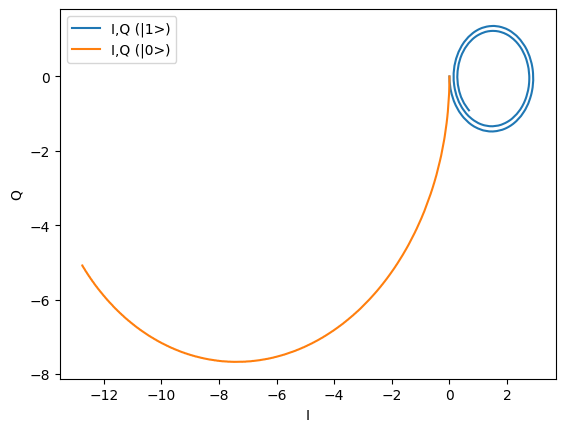

In [12]:
plt.figure()
plt.plot(I_1, Q_1, label='I,Q (|1>)')
plt.plot(I_0, Q_0, label='I,Q (|0>)')
# plt.plot(t_meas_1, Q_1, label='Q (|1>)')
# plt.plot(tlist_0, I_0, label='I (|0>)')
# plt.plot(tlist_0, Q_0, label='Q (|0>)')
plt.xlabel('I')
plt.ylabel('Q')
plt.legend()
plt.show()

DME